# Análise de Correspondência - Consolidação de Estatísticas de Futebol

Este notebook consolida todas as estatísticas de jogadores e times para preparar dados para análise de correspondência.

## Objetivos:
1. Consolidar estatísticas por jogador (removendo duplicatas)
2. Agregar estatísticas por time
3. Criar tabela fato para análise de correspondência
4. Exportar todas as tabelas como CSV

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Configurações de exibição
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)

print("Bibliotecas carregadas com sucesso!")

Bibliotecas carregadas com sucesso!


## 1. Carregamento e Análise dos Dados

Primeiro vamos carregar todas as tabelas e analisar sua estrutura.

In [2]:
# Carregando todos os datasets
sumario = pd.read_csv('sumario_jogo.csv')
passing = pd.read_csv('players_passing_stats.csv')
offensive = pd.read_csv('players_offensive_stats.csv')
defensive = pd.read_csv('players_defensive_stats.csv')

# Informações básicas dos datasets
datasets = {
    'Sumário do Jogo': sumario,
    'Estatísticas de Passe': passing,
    'Estatísticas Ofensivas': offensive,
    'Estatísticas Defensivas': defensive
}

print("=== INFORMAÇÕES DOS DATASETS ===")
for nome, df in datasets.items():
    print(f"\n{nome}:")
    print(f"  - Dimensões: {df.shape}")
    print(f"  - Jogadores únicos: {df['Player'].nunique()}")
    print(f"  - Times: {df['Team'].unique()}")

=== INFORMAÇÕES DOS DATASETS ===

Sumário do Jogo:
  - Dimensões: (31, 11)
  - Jogadores únicos: 31
  - Times: ['Inter' 'Fluminense']

Estatísticas de Passe:
  - Dimensões: (31, 14)
  - Jogadores únicos: 31
  - Times: ['Inter' 'Fluminense']

Estatísticas Ofensivas:
  - Dimensões: (31, 13)
  - Jogadores únicos: 31
  - Times: ['Inter' 'Fluminense']

Estatísticas Defensivas:
  - Dimensões: (31, 10)
  - Jogadores únicos: 31
  - Times: ['Inter' 'Fluminense']


In [3]:
# Analisando colunas de cada dataset
print("=== COLUNAS POR DATASET ===")
for nome, df in datasets.items():
    print(f"\n{nome}:")
    print(f"  Colunas: {list(df.columns)}")

=== COLUNAS POR DATASET ===

Sumário do Jogo:
  Colunas: ['Player', 'Age', 'Position', 'Shots', 'ShotsOT', 'KeyPasses', 'PA%', 'AerialsWon', 'Touches', 'Rating', 'Team']

Estatísticas de Passe:
  Colunas: ['Player', 'Age', 'Position', 'KeyPasses', 'Passes', 'PA%', 'Crosses', 'AccCrosses', 'LongBalls', 'AccLongBalls', 'ThroughBalls', 'AccThroughBalls', 'Rating', 'Team']

Estatísticas Ofensivas:
  Colunas: ['Player', 'Age', 'Position', 'Shots', 'ShotsOT', 'KeyPasses', 'Dribbles', 'Fouled', 'Offsides', 'Dispossessed', 'UnsuccessfulTouches', 'Rating', 'Team']

Estatísticas Defensivas:
  Colunas: ['Player', 'Age', 'Position', 'TotalTackles', 'Interceptions', 'Clearances', 'BlockedShots', 'Fouls', 'Rating', 'Team']


## 2. Identificação de Colunas Duplicadas

Vamos identificar quais colunas aparecem em múltiplos datasets.

In [4]:
# Identificando colunas comuns entre datasets
all_columns = {}
for nome, df in datasets.items():
    all_columns[nome] = set(df.columns)

# Colunas que aparecem em múltiplos datasets
colunas_duplicadas = {}
for col in sumario.columns:
    datasets_com_coluna = []
    for nome, colunas in all_columns.items():
        if col in colunas:
            datasets_com_coluna.append(nome)

    if len(datasets_com_coluna) > 1:
        colunas_duplicadas[col] = datasets_com_coluna

print("=== COLUNAS DUPLICADAS ===")
for col, datasets_list in colunas_duplicadas.items():
    print(f"{col}: {datasets_list}")

=== COLUNAS DUPLICADAS ===
Player: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas', 'Estatísticas Defensivas']
Age: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas', 'Estatísticas Defensivas']
Position: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas', 'Estatísticas Defensivas']
Shots: ['Sumário do Jogo', 'Estatísticas Ofensivas']
ShotsOT: ['Sumário do Jogo', 'Estatísticas Ofensivas']
KeyPasses: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas']
PA%: ['Sumário do Jogo', 'Estatísticas de Passe']
Rating: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas', 'Estatísticas Defensivas']
Team: ['Sumário do Jogo', 'Estatísticas de Passe', 'Estatísticas Ofensivas', 'Estatísticas Defensivas']


In [5]:
# Verificando se os valores das colunas duplicadas são consistentes
print("=== VERIFICAÇÃO DE CONSISTÊNCIA ===")

# Verificando KeyPasses (aparece em sumario, passing e offensive)
if 'KeyPasses' in colunas_duplicadas:
    print("\nVerificando KeyPasses:")
    # Merge para comparar
    temp_merge = sumario[['Player', 'KeyPasses']].merge(
        passing[['Player', 'KeyPasses']], on='Player', suffixes=('_sumario', '_passing')
    )
    temp_merge = temp_merge.merge(
        offensive[['Player', 'KeyPasses']], on='Player'
    )
    temp_merge.rename(
        columns={'KeyPasses': 'KeyPasses_offensive'}, inplace=True)

    # Verificando diferenças
    diff1 = (temp_merge['KeyPasses_sumario'] !=
             temp_merge['KeyPasses_passing']).sum()
    diff2 = (temp_merge['KeyPasses_sumario'] !=
             temp_merge['KeyPasses_offensive']).sum()

    print(f"  Diferenças sumario vs passing: {diff1}")
    print(f"  Diferenças sumario vs offensive: {diff2}")

    if diff1 == 0 and diff2 == 0:
        print("  ✓ KeyPasses é consistente entre todos os datasets")
    else:
        print("  ⚠ KeyPasses tem diferenças entre datasets")

=== VERIFICAÇÃO DE CONSISTÊNCIA ===

Verificando KeyPasses:
  Diferenças sumario vs passing: 0
  Diferenças sumario vs offensive: 0
  ✓ KeyPasses é consistente entre todos os datasets


## 3. Consolidação da Tabela de Jogadores

Vamos consolidar todas as estatísticas em uma única tabela por jogador, removendo duplicatas.

In [6]:
# Definindo colunas de identificação que devem ser mantidas apenas uma vez
colunas_identificacao = ['Player', 'Age', 'Position', 'Team', 'Rating']

# Começando com o sumário como base
estatisticas_jogadores = sumario.copy()

print("=== PROCESSO DE CONSOLIDAÇÃO ===")
print(f"Base inicial (sumário): {estatisticas_jogadores.shape}")

# Adicionando colunas únicas de passing
colunas_passing_unicas = [col for col in passing.columns
                          if col not in estatisticas_jogadores.columns or col == 'Player']

if len(colunas_passing_unicas) > 1:  # Mais que apenas 'Player'
    passing_unicas = passing[colunas_passing_unicas]
    estatisticas_jogadores = estatisticas_jogadores.merge(
        passing_unicas, on='Player', how='left'
    )
    print(f"Após adicionar passing: {estatisticas_jogadores.shape}")
    print(
        f"Colunas adicionadas de passing: {[col for col in colunas_passing_unicas if col != 'Player']}")

# Adicionando colunas únicas de offensive
colunas_offensive_unicas = [col for col in offensive.columns
                            if col not in estatisticas_jogadores.columns or col == 'Player']

if len(colunas_offensive_unicas) > 1:
    offensive_unicas = offensive[colunas_offensive_unicas]
    estatisticas_jogadores = estatisticas_jogadores.merge(
        offensive_unicas, on='Player', how='left'
    )
    print(f"Após adicionar offensive: {estatisticas_jogadores.shape}")
    print(
        f"Colunas adicionadas de offensive: {[col for col in colunas_offensive_unicas if col != 'Player']}")

# Adicionando colunas únicas de defensive
colunas_defensive_unicas = [col for col in defensive.columns
                            if col not in estatisticas_jogadores.columns or col == 'Player']

if len(colunas_defensive_unicas) > 1:
    defensive_unicas = defensive[colunas_defensive_unicas]
    estatisticas_jogadores = estatisticas_jogadores.merge(
        defensive_unicas, on='Player', how='left'
    )
    print(f"Após adicionar defensive: {estatisticas_jogadores.shape}")
    print(
        f"Colunas adicionadas de defensive: {[col for col in colunas_defensive_unicas if col != 'Player']}")

print(f"\nTabela consolidada final: {estatisticas_jogadores.shape}")

=== PROCESSO DE CONSOLIDAÇÃO ===
Base inicial (sumário): (31, 11)
Após adicionar passing: (31, 18)
Colunas adicionadas de passing: ['Passes', 'Crosses', 'AccCrosses', 'LongBalls', 'AccLongBalls', 'ThroughBalls', 'AccThroughBalls']
Após adicionar offensive: (31, 23)
Colunas adicionadas de offensive: ['Dribbles', 'Fouled', 'Offsides', 'Dispossessed', 'UnsuccessfulTouches']
Após adicionar defensive: (31, 28)
Colunas adicionadas de defensive: ['TotalTackles', 'Interceptions', 'Clearances', 'BlockedShots', 'Fouls']

Tabela consolidada final: (31, 28)


In [7]:
# Visualizando a tabela consolidada
print("=== TABELA CONSOLIDADA DE JOGADORES ===")
print(f"Colunas finais ({len(estatisticas_jogadores.columns)}):")
for i, col in enumerate(estatisticas_jogadores.columns, 1):
    print(f"{i:2d}. {col}")

print(f"\nPrimeiras 3 linhas:")
print(estatisticas_jogadores.head(3))

=== TABELA CONSOLIDADA DE JOGADORES ===
Colunas finais (28):
 1. Player
 2. Age
 3. Position
 4. Shots
 5. ShotsOT
 6. KeyPasses
 7. PA%
 8. AerialsWon
 9. Touches
10. Rating
11. Team
12. Passes
13. Crosses
14. AccCrosses
15. LongBalls
16. AccLongBalls
17. ThroughBalls
18. AccThroughBalls
19. Dribbles
20. Fouled
21. Offsides
22. Dispossessed
23. UnsuccessfulTouches
24. TotalTackles
25. Interceptions
26. Clearances
27. BlockedShots
28. Fouls

Primeiras 3 linhas:
               Player  Age Position  Shots  ShotsOT  KeyPasses   PA%  \
0         Yann Sommer   36       GK      0        0          0  96.4   
1      Matteo Darmian   35       DC      0        0          0  87.5   
2  Alessandro Bastoni   26       DC      0        0          0  84.0   

   AerialsWon  Touches  Rating   Team  Passes  Crosses  AccCrosses  LongBalls  \
0           0       32    5.22  Inter      28        0           0          2   
1           2       58    6.24  Inter      40        2           1          3   
2 

In [8]:
# Salvando tabela consolidada de jogadores
estatisticas_jogadores.to_csv(
    'estatisticas_jogadores_consolidada.csv', index=False)
print("✓ Tabela consolidada de jogadores salva como 'estatisticas_jogadores_consolidada.csv'")

# Verificando valores faltantes
print(f"\nValores faltantes por coluna:")
missing_values = estatisticas_jogadores.isnull().sum()
if missing_values.sum() > 0:
    print(missing_values[missing_values > 0])
else:
    print("Nenhum valor faltante encontrado!")

✓ Tabela consolidada de jogadores salva como 'estatisticas_jogadores_consolidada.csv'

Valores faltantes por coluna:
Nenhum valor faltante encontrado!


## 4. Agregação por Time

Agora vamos criar estatísticas agregadas por time.

In [9]:
# Identificando colunas numéricas para agregação
colunas_numericas = estatisticas_jogadores.select_dtypes(
    include=[np.number]).columns.tolist()

# Colunas que precisam de tratamento especial
colunas_especiais = {
    'Age': 'mean',        # Idade média
    'Rating': 'mean',     # Rating médio
    'PA%': 'mean'         # Porcentagem de passes média
}

# Colunas para somar (estatísticas de jogo)
colunas_soma = [
    col for col in colunas_numericas if col not in colunas_especiais.keys()]

print("=== ESTRATÉGIA DE AGREGAÇÃO ===")
print(f"Colunas para média: {list(colunas_especiais.keys())}")
print(f"Colunas para soma: {colunas_soma}")

=== ESTRATÉGIA DE AGREGAÇÃO ===
Colunas para média: ['Age', 'Rating', 'PA%']
Colunas para soma: ['Shots', 'ShotsOT', 'KeyPasses', 'AerialsWon', 'Touches', 'Passes', 'Crosses', 'AccCrosses', 'LongBalls', 'AccLongBalls', 'ThroughBalls', 'AccThroughBalls', 'Dribbles', 'Fouled', 'Offsides', 'Dispossessed', 'UnsuccessfulTouches', 'TotalTackles', 'Interceptions', 'Clearances', 'BlockedShots', 'Fouls']


In [10]:
# Criando agregações por time
agregacoes = {
    'Player': 'count',  # Número de jogadores
}

# Adicionando agregações especiais
agregacoes.update(colunas_especiais)

# Adicionando somas
for col in colunas_soma:
    agregacoes[col] = 'sum'

# Aplicando agregações
estatisticas_times = estatisticas_jogadores.groupby(
    'Team').agg(agregacoes).round(2)

# Renomeando colunas para clareza
estatisticas_times.rename(columns={
    'Player': 'NumJogadores',
    'Age': 'IdadeMedia',
    'Rating': 'RatingMedio'
}, inplace=True)

print("=== ESTATÍSTICAS POR TIME ===")
print(f"Dimensões: {estatisticas_times.shape}")
print(f"\nTabela de estatísticas por time:")
print(estatisticas_times)

=== ESTATÍSTICAS POR TIME ===
Dimensões: (2, 26)

Tabela de estatísticas por time:
            NumJogadores  IdadeMedia  RatingMedio    PA%  Shots  ShotsOT  \
Team                                                                       
Fluminense            15       30.67         6.92  63.36     11        4   
Inter                 16       27.44         6.24  86.02     16        4   

            KeyPasses  AerialsWon  Touches  Passes  Crosses  AccCrosses  \
Team                                                                      
Fluminense          7          10      444     240        8           4   
Inter              11          18      689     507       27           5   

            LongBalls  AccLongBalls  ThroughBalls  AccThroughBalls  Dribbles  \
Team                                                                           
Fluminense         47            17             0                0         4   
Inter              35            22             2                0     

In [11]:
# Salvando estatísticas por time
estatisticas_times.to_csv('estatisticas_times_agregadas.csv')
print("✓ Estatísticas por time salvas como 'estatisticas_times_agregadas.csv'")

# Estatísticas descritivas
print(f"\nEstatísticas descritivas:")
print(estatisticas_times.describe())

✓ Estatísticas por time salvas como 'estatisticas_times_agregadas.csv'

Estatísticas descritivas:
       NumJogadores  IdadeMedia  RatingMedio       PA%      Shots  ShotsOT  \
count      2.000000    2.000000     2.000000   2.00000   2.000000      2.0   
mean      15.500000   29.055000     6.580000  74.69000  13.500000      4.0   
std        0.707107    2.283955     0.480833  16.02304   3.535534      0.0   
min       15.000000   27.440000     6.240000  63.36000  11.000000      4.0   
25%       15.250000   28.247500     6.410000  69.02500  12.250000      4.0   
50%       15.500000   29.055000     6.580000  74.69000  13.500000      4.0   
75%       15.750000   29.862500     6.750000  80.35500  14.750000      4.0   
max       16.000000   30.670000     6.920000  86.02000  16.000000      4.0   

       KeyPasses  AerialsWon     Touches      Passes    Crosses  AccCrosses  \
count   2.000000    2.000000    2.000000    2.000000   2.000000    2.000000   
mean    9.000000   14.000000  566.500000 

## 5. Criação da Tabela Fato para Análise de Correspondência

Vamos criar diferentes versões da tabela fato para análise de correspondência.

In [12]:
# Versão 1: Tabela fato completa (todas as estatísticas numéricas)
tabela_fato_completa = estatisticas_times.copy()

# Removendo colunas não adequadas para análise de correspondência
colunas_remover = ['NumJogadores', 'IdadeMedia', 'RatingMedio']
if 'PA%' in tabela_fato_completa.columns:
    colunas_remover.append('PA%')

tabela_fato_completa = tabela_fato_completa.drop(columns=[col for col in colunas_remover
                                                          if col in tabela_fato_completa.columns])

print("=== TABELA FATO COMPLETA ===")
print(f"Dimensões: {tabela_fato_completa.shape}")
print(f"Estatísticas incluídas: {list(tabela_fato_completa.columns)}")
print(f"\nTabela fato completa:")
print(tabela_fato_completa)

=== TABELA FATO COMPLETA ===
Dimensões: (2, 22)
Estatísticas incluídas: ['Shots', 'ShotsOT', 'KeyPasses', 'AerialsWon', 'Touches', 'Passes', 'Crosses', 'AccCrosses', 'LongBalls', 'AccLongBalls', 'ThroughBalls', 'AccThroughBalls', 'Dribbles', 'Fouled', 'Offsides', 'Dispossessed', 'UnsuccessfulTouches', 'TotalTackles', 'Interceptions', 'Clearances', 'BlockedShots', 'Fouls']

Tabela fato completa:
            Shots  ShotsOT  KeyPasses  AerialsWon  Touches  Passes  Crosses  \
Team                                                                          
Fluminense     11        4          7          10      444     240        8   
Inter          16        4         11          18      689     507       27   

            AccCrosses  LongBalls  AccLongBalls  ThroughBalls  \
Team                                                            
Fluminense           4         47            17             0   
Inter                5         35            22             2   

            AccThroughBa

In [13]:
# Versão 2: Tabela fato simplificada (categorias principais)
print("=== CRIANDO TABELA FATO SIMPLIFICADA ===")

# Definindo categorias principais
categorias = {}

# Estatísticas ofensivas
if all(col in tabela_fato_completa.columns for col in ['Shots', 'ShotsOT', 'Dribbles']):
    categorias['Ataque'] = tabela_fato_completa['Shots'] + \
        tabela_fato_completa['ShotsOT'] + tabela_fato_completa['Dribbles']

# Estatísticas de passe
if all(col in tabela_fato_completa.columns for col in ['Passes', 'Crosses', 'LongBalls']):
    categorias['Passe'] = tabela_fato_completa['Passes'] + \
        tabela_fato_completa['Crosses'] + tabela_fato_completa['LongBalls']

# Estatísticas defensivas
colunas_defesa = ['TotalTackles',
                  'Interceptions', 'Clearances', 'BlockedShots']
colunas_defesa_disponiveis = [
    col for col in colunas_defesa if col in tabela_fato_completa.columns]
if colunas_defesa_disponiveis:
    categorias['Defesa'] = tabela_fato_completa[colunas_defesa_disponiveis].sum(
        axis=1)

# Controle de jogo
if 'Touches' in tabela_fato_completa.columns:
    categorias['ControleBola'] = tabela_fato_completa['Touches']

# Disciplina
if 'Fouls' in tabela_fato_completa.columns:
    categorias['Faltas'] = tabela_fato_completa['Fouls']

# Criando tabela simplificada
tabela_fato_simplificada = pd.DataFrame(
    categorias, index=tabela_fato_completa.index)

print(f"Categorias criadas: {list(categorias.keys())}")
print(f"\nTabela fato simplificada:")
print(tabela_fato_simplificada)

=== CRIANDO TABELA FATO SIMPLIFICADA ===
Categorias criadas: ['Ataque', 'Passe', 'Defesa', 'ControleBola', 'Faltas']

Tabela fato simplificada:
            Ataque  Passe  Defesa  ControleBola  Faltas
Team                                                   
Fluminense      19    295      72           444      16
Inter           26    569      28           689      15


In [14]:
# Salvando as tabelas fato
tabela_fato_completa.to_csv('tabela_fato_correspondencia_completa.csv')
tabela_fato_simplificada.to_csv('tabela_fato_correspondencia_simplificada.csv')

print("✓ Tabela fato completa salva como 'tabela_fato_correspondencia_completa.csv'")
print("✓ Tabela fato simplificada salva como 'tabela_fato_correspondencia_simplificada.csv'")

✓ Tabela fato completa salva como 'tabela_fato_correspondencia_completa.csv'
✓ Tabela fato simplificada salva como 'tabela_fato_correspondencia_simplificada.csv'


## 6. Visualizações Exploratórias

Vamos criar algumas visualizações para entender melhor os dados.

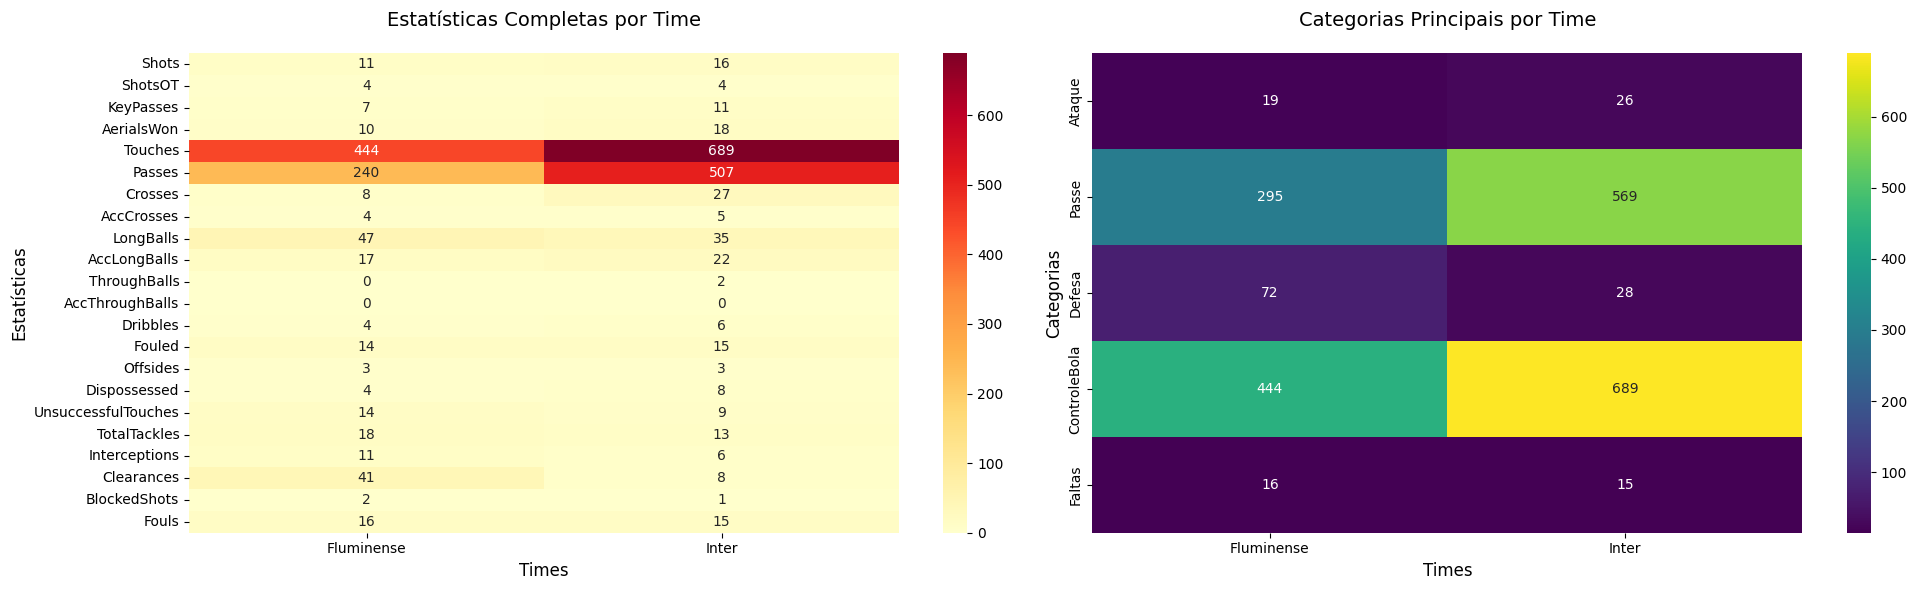

In [15]:
# Configuração de visualização
plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)

# Heatmap da tabela fato completa
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Heatmap completa
sns.heatmap(tabela_fato_completa.T, annot=True,
            cmap='YlOrRd', fmt='.0f', ax=ax1)
ax1.set_title('Estatísticas Completas por Time', fontsize=14, pad=20)
ax1.set_xlabel('Times', fontsize=12)
ax1.set_ylabel('Estatísticas', fontsize=12)

# Heatmap simplificada
sns.heatmap(tabela_fato_simplificada.T, annot=True,
            cmap='viridis', fmt='.0f', ax=ax2)
ax2.set_title('Categorias Principais por Time', fontsize=14, pad=20)
ax2.set_xlabel('Times', fontsize=12)
ax2.set_ylabel('Categorias', fontsize=12)

plt.tight_layout()
plt.show()

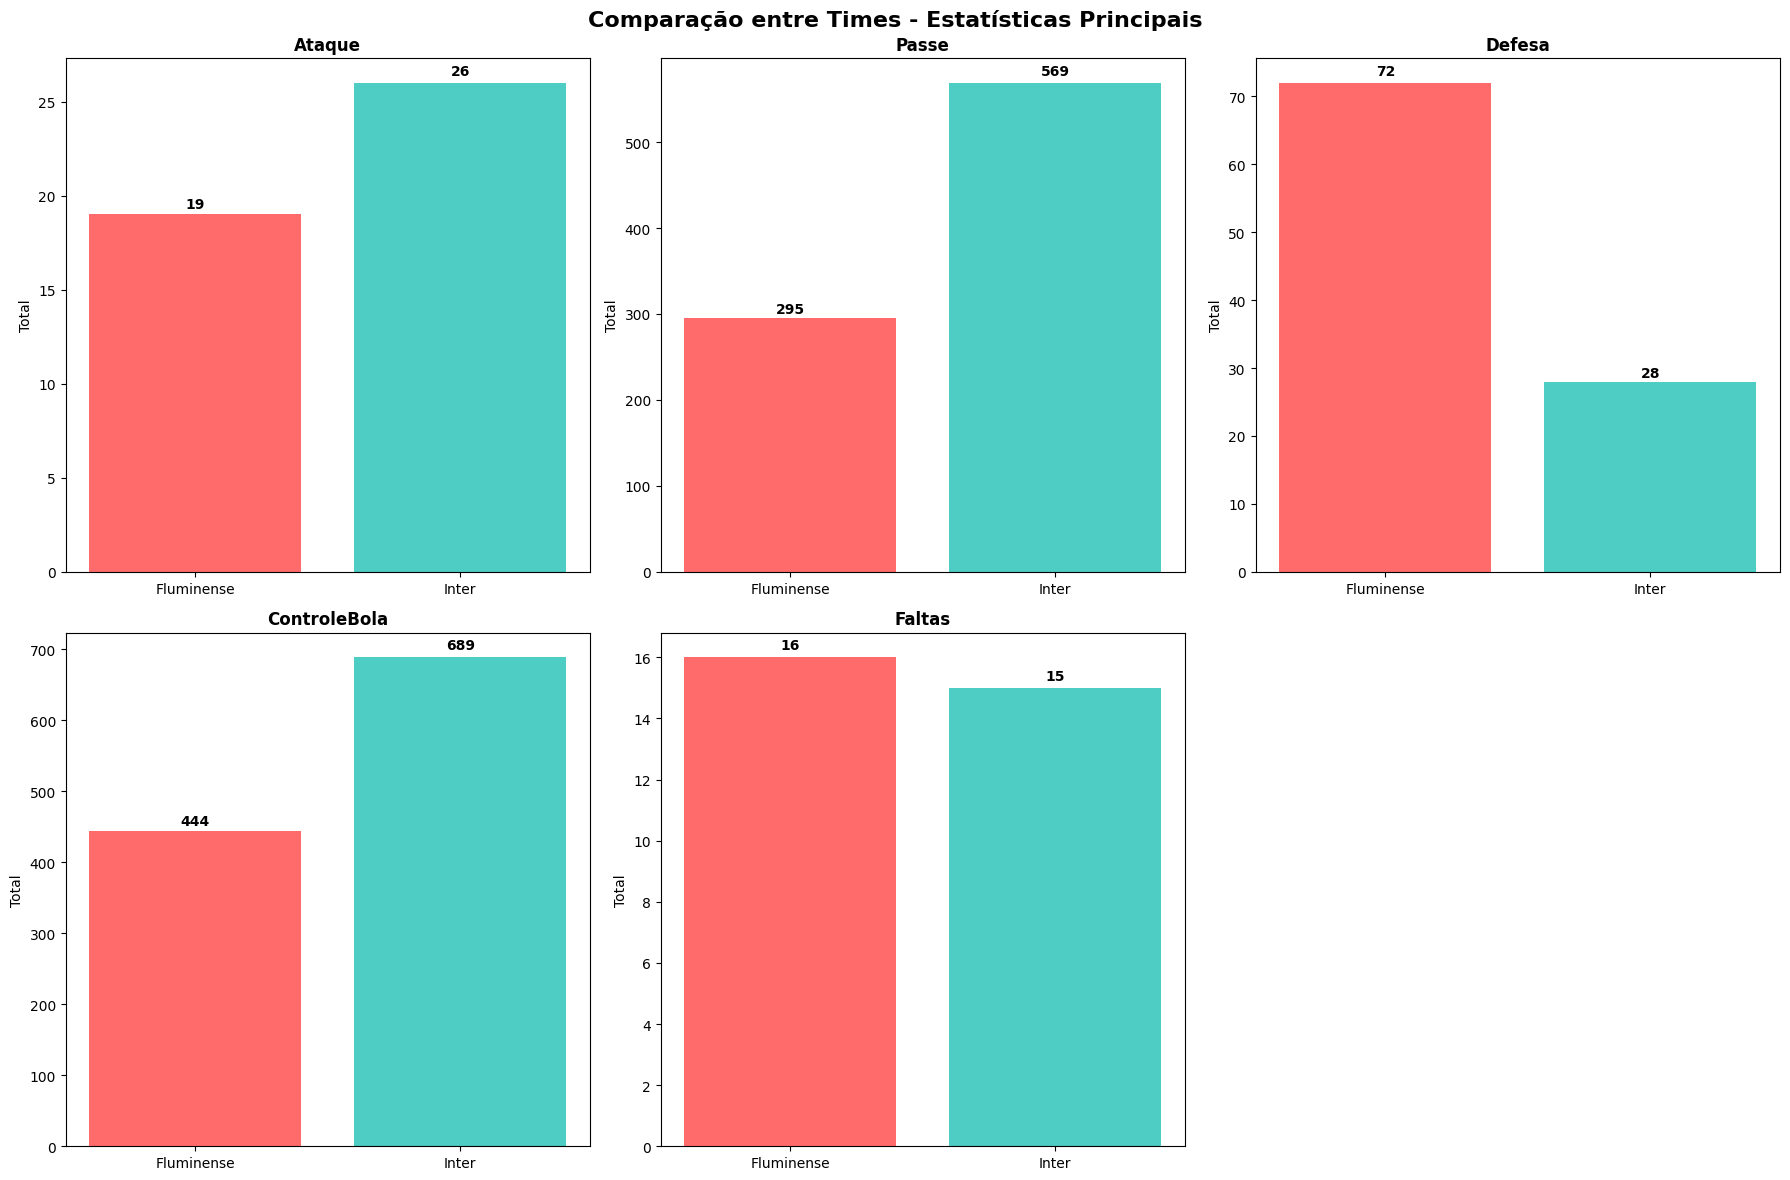

In [16]:
# Comparação entre times - categorias principais
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

cores = ['#FF6B6B', '#4ECDC4']  # Cores para os times

for i, categoria in enumerate(tabela_fato_simplificada.columns):
    if i < len(axes):
        valores = tabela_fato_simplificada[categoria]
        ax = axes[i]

        bars = ax.bar(valores.index, valores.values,
                      color=cores[:len(valores)])
        ax.set_title(f'{categoria}', fontsize=12, fontweight='bold')
        ax.set_ylabel('Total', fontsize=10)

        # Adicionando valores nas barras
        for bar, valor in zip(bars, valores.values):
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                    f'{int(valor)}', ha='center', va='bottom', fontweight='bold')

# Removendo eixos não utilizados
for i in range(len(tabela_fato_simplificada.columns), len(axes)):
    axes[i].remove()

plt.suptitle('Comparação entre Times - Estatísticas Principais',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

## 7. Análise Comparativa entre Times

Vamos fazer uma análise comparativa detalhada entre os times.

In [17]:
# Análise comparativa detalhada
print("=== ANÁLISE COMPARATIVA ENTRE TIMES ===")

times = tabela_fato_simplificada.index.tolist()
print(f"Times analisados: {times}")

# Calculando diferenças percentuais
if len(times) == 2:
    time1, time2 = times[0], times[1]

    print(f"\n{time1} vs {time2}:")
    print("-" * 50)

    for categoria in tabela_fato_simplificada.columns:
        val1 = tabela_fato_simplificada.loc[time1, categoria]
        val2 = tabela_fato_simplificada.loc[time2, categoria]

        if val2 != 0:
            diff_perc = ((val1 - val2) / val2) * 100
            maior = time1 if val1 > val2 else time2

            print(
                f"{categoria:15s}: {time1} {val1:6.0f} | {time2} {val2:6.0f} | Vantagem: {maior} ({abs(diff_perc):5.1f}%)")
        else:
            print(
                f"{categoria:15s}: {time1} {val1:6.0f} | {time2} {val2:6.0f} | Sem comparação possível")

=== ANÁLISE COMPARATIVA ENTRE TIMES ===
Times analisados: ['Fluminense', 'Inter']

Fluminense vs Inter:
--------------------------------------------------
Ataque         : Fluminense     19 | Inter     26 | Vantagem: Inter ( 26.9%)
Passe          : Fluminense    295 | Inter    569 | Vantagem: Inter ( 48.2%)
Defesa         : Fluminense     72 | Inter     28 | Vantagem: Fluminense (157.1%)
ControleBola   : Fluminense    444 | Inter    689 | Vantagem: Inter ( 35.6%)
Faltas         : Fluminense     16 | Inter     15 | Vantagem: Fluminense (  6.7%)


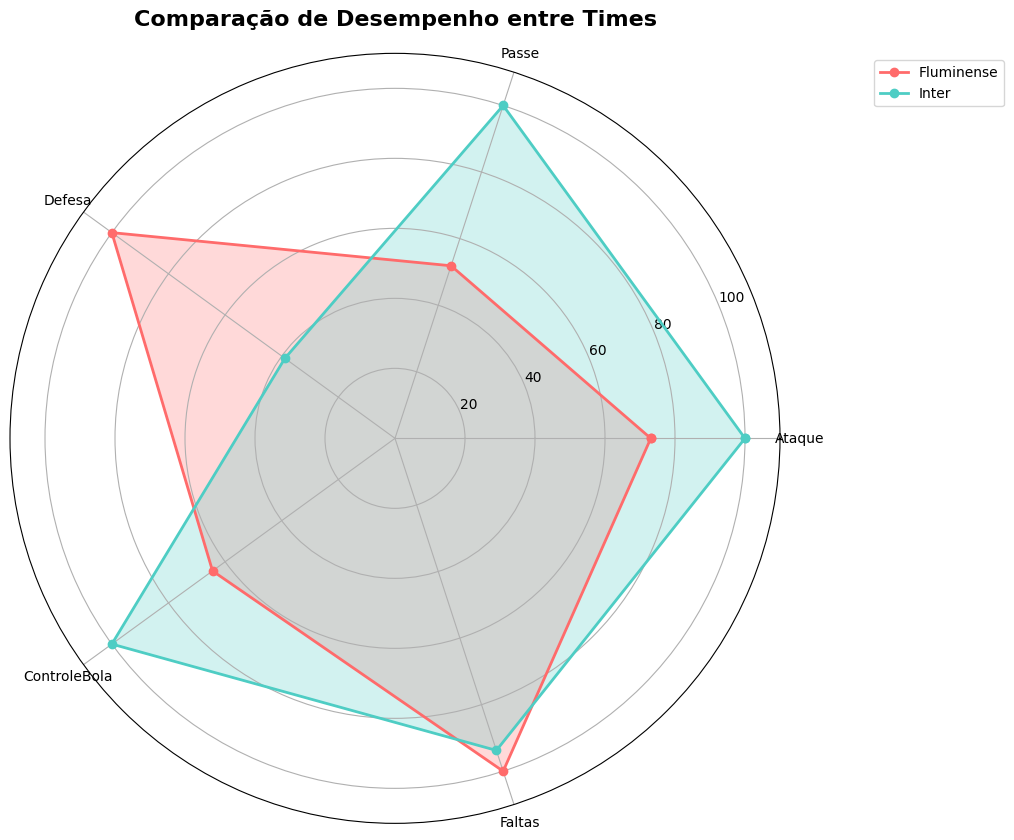

In [18]:
# Criando um radar chart para comparação visual
import matplotlib.pyplot as plt
import numpy as np


def criar_radar_chart(dados, times, titulo):
    # Número de variáveis
    num_vars = len(dados.columns)

    # Ângulos para cada eixo
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]  # Completar o círculo

    # Criar figura
    fig, ax = plt.subplots(
        figsize=(10, 10), subplot_kw=dict(projection='polar'))

    # Cores para cada time
    cores = ['#FF6B6B', '#4ECDC4', '#45B7D1', '#96CEB4']

    # Plotar dados para cada time
    for i, time in enumerate(times):
        valores = dados.loc[time].tolist()
        valores += valores[:1]  # Completar o círculo

        ax.plot(angles, valores, 'o-', linewidth=2, label=time, color=cores[i])
        ax.fill(angles, valores, alpha=0.25, color=cores[i])

    # Configurar eixos
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(dados.columns)
    ax.set_ylim(0, dados.values.max() * 1.1)

    # Adicionar título e legenda
    plt.title(titulo, size=16, fontweight='bold', pad=20)
    plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0))

    return fig


# Normalizar dados para o radar chart (0-100)
dados_normalizados = tabela_fato_simplificada.copy()
for col in dados_normalizados.columns:
    max_val = dados_normalizados[col].max()
    if max_val > 0:
        dados_normalizados[col] = (dados_normalizados[col] / max_val) * 100

# Criar radar chart
if len(times) > 0:
    fig = criar_radar_chart(dados_normalizados, times,
                            'Comparação de Desempenho entre Times')
    plt.show()

## 8. Resumo e Arquivos Gerados

Vamos fazer um resumo final e listar todos os arquivos gerados.

In [19]:
# Verificando arquivos gerados
import os

arquivos_gerados = [
    'estatisticas_jogadores_consolidada.csv',
    'estatisticas_times_agregadas.csv',
    'tabela_fato_correspondencia_completa.csv',
    'tabela_fato_correspondencia_simplificada.csv'
]

print("=== RESUMO DOS ARQUIVOS GERADOS ===")
print()

for arquivo in arquivos_gerados:
    if os.path.exists(arquivo):
        # Carregar para mostrar dimensões
        df = pd.read_csv(arquivo)
        print(f"✓ {arquivo}")
        print(f"   Dimensões: {df.shape}")
        print(f"   Colunas: {df.shape[1]}")
        print()
    else:
        print(f"✗ {arquivo} - NÃO ENCONTRADO")
        print()

=== RESUMO DOS ARQUIVOS GERADOS ===

✓ estatisticas_jogadores_consolidada.csv
   Dimensões: (31, 28)
   Colunas: 28

✓ estatisticas_times_agregadas.csv
   Dimensões: (2, 27)
   Colunas: 27

✓ tabela_fato_correspondencia_completa.csv
   Dimensões: (2, 23)
   Colunas: 23

✓ tabela_fato_correspondencia_simplificada.csv
   Dimensões: (2, 6)
   Colunas: 6



In [20]:
# Resumo final das análises
print("=== RESUMO FINAL ===")
print()
print("1. CONSOLIDAÇÃO DE DADOS:")
print(f"   • {len(datasets)} datasets originais consolidados")
print(f"   • {len(colunas_duplicadas)} colunas duplicadas identificadas e tratadas")
print(f"   • {estatisticas_jogadores.shape[0]} jogadores consolidados")
print(f"   • {estatisticas_jogadores.shape[1]} estatísticas por jogador")
print()

print("2. AGREGAÇÃO POR TIME:")
print(f"   • {len(times)} times analisados")
print(
    f"   • {tabela_fato_completa.shape[1]} estatísticas agregadas (versão completa)")
print(
    f"   • {tabela_fato_simplificada.shape[1]} categorias principais (versão simplificada)")
print()

print("3. TABELAS PARA ANÁLISE DE CORRESPONDÊNCIA:")
print("   • Tabela completa: matriz times x todas as estatísticas")
print("   • Tabela simplificada: matriz times x categorias principais")
print("   • Ambas prontas para análise de correspondência")
print()

print("4. PRÓXIMOS PASSOS RECOMENDADOS:")
print("   • Use 'tabela_fato_correspondencia_simplificada.csv' para análise inicial")
print("   • Use 'tabela_fato_correspondencia_completa.csv' para análise detalhada")
print("   • Aplique técnicas de análise de correspondência (CA)")
print("   • Interprete os resultados considerando o contexto do jogo")

=== RESUMO FINAL ===

1. CONSOLIDAÇÃO DE DADOS:
   • 4 datasets originais consolidados
   • 9 colunas duplicadas identificadas e tratadas
   • 31 jogadores consolidados
   • 28 estatísticas por jogador

2. AGREGAÇÃO POR TIME:
   • 2 times analisados
   • 22 estatísticas agregadas (versão completa)
   • 5 categorias principais (versão simplificada)

3. TABELAS PARA ANÁLISE DE CORRESPONDÊNCIA:
   • Tabela completa: matriz times x todas as estatísticas
   • Tabela simplificada: matriz times x categorias principais
   • Ambas prontas para análise de correspondência

4. PRÓXIMOS PASSOS RECOMENDADOS:
   • Use 'tabela_fato_correspondencia_simplificada.csv' para análise inicial
   • Use 'tabela_fato_correspondencia_completa.csv' para análise detalhada
   • Aplique técnicas de análise de correspondência (CA)
   • Interprete os resultados considerando o contexto do jogo


## Conclusão

O processo de consolidação foi concluído com sucesso! 

### Arquivos Gerados:
1. **`estatisticas_jogadores_consolidada.csv`** - Todas as estatísticas por jogador (sem duplicatas)
2. **`estatisticas_times_agregadas.csv`** - Estatísticas agregadas por time
3. **`tabela_fato_correspondencia_completa.csv`** - Matriz completa para análise de correspondência
4. **`tabela_fato_correspondencia_simplificada.csv`** - Matriz simplificada com categorias principais

### Para Análise de Correspondência:
- **Linhas**: Times (Inter, Fluminense)  
- **Colunas**: Estatísticas/Categorias de jogo
- **Valores**: Totais agregados por time

As tabelas estão prontas para análise de correspondência usando bibliotecas como `prince`, `sklearn` ou `ca` em R.